In [1]:
import os



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

def read_data(file_path):

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df


def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan
    
def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan
 

 
def show_basic_dataframe_info(dataframe):

    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

# Load data set containing all the data from csv
dataset = read_data('Outputs/WISDM_ar_v1.1_raw.txt')
dataset.head()

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [3]:
def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma
    
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
def plot_activity(activity,data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (15, 10), sharex = True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

In [4]:
#dataset = read_data("Outputs/WISDM_ar_v1.1_raw.txt")
dataset.dropna(axis=0, how='any', inplace= True)
dataset['x-axis'] = feature_normalize(dataset['x-axis'])
dataset['y-axis'] = feature_normalize(dataset['y-axis'])
dataset['z-axis'] = feature_normalize(dataset['z-axis'])

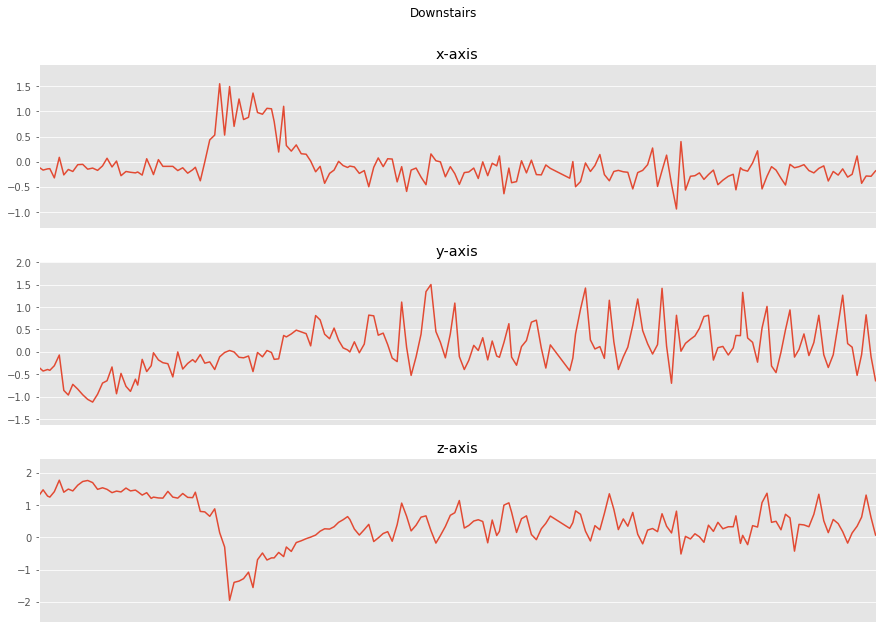

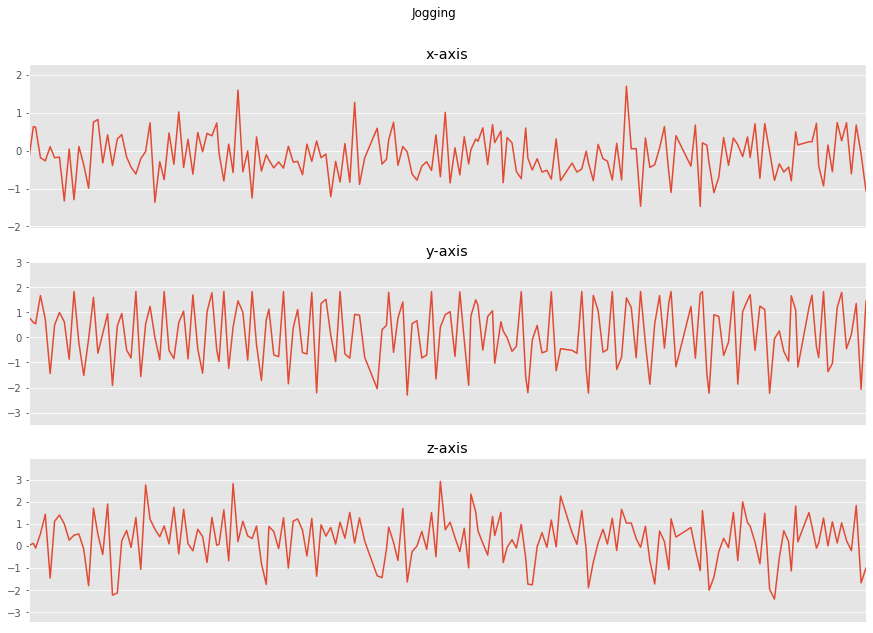

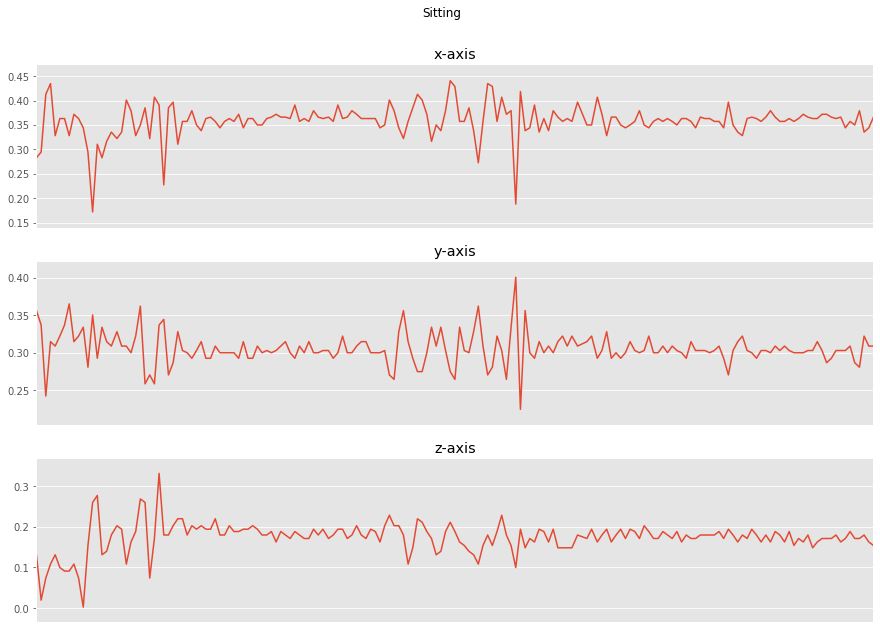

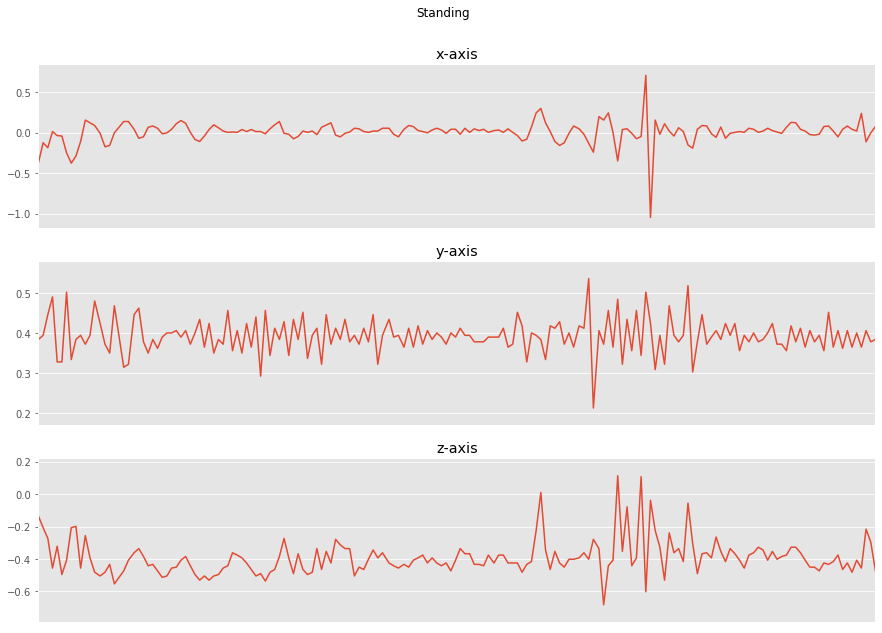

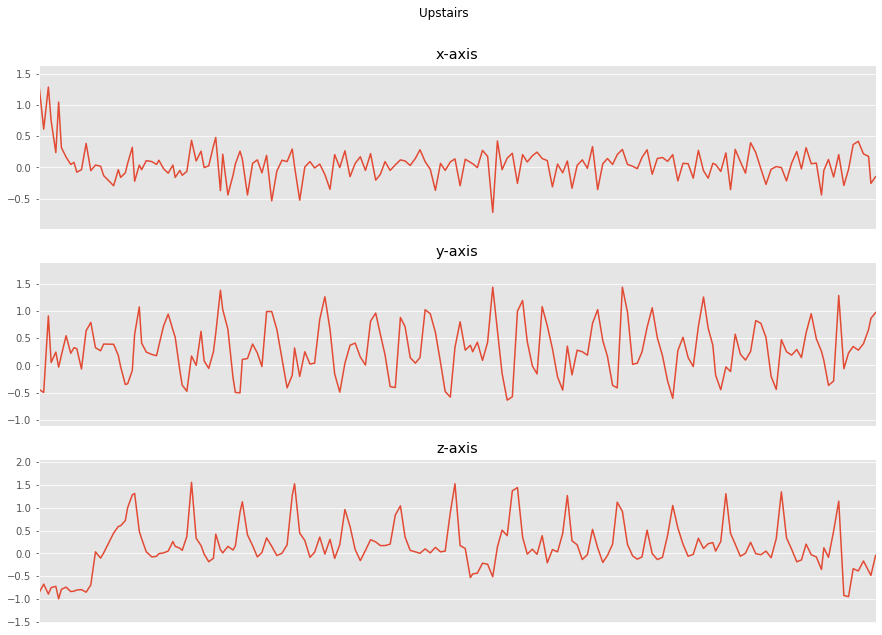

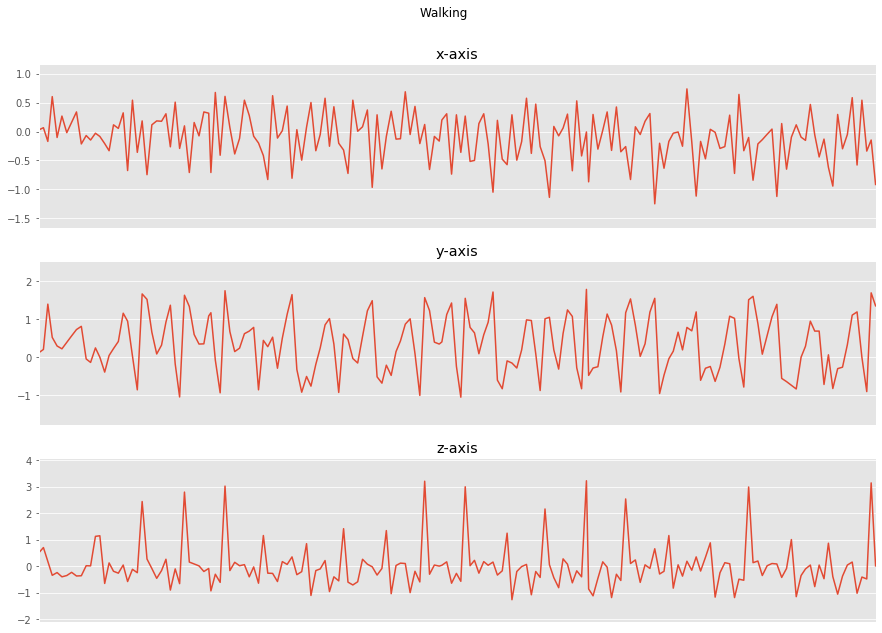

In [5]:
for activity in np.unique(dataset["activity"]):
    subset = dataset[dataset["activity"] == activity][:180]
    plot_activity(activity,subset)

In [6]:
#coding the text data for activity into codes
dataset.activity = pd.Categorical(dataset.activity)
dataset['Activity_code'] = dataset.activity.cat.codes

In [7]:
# the labels for the activity
#0 Downstairs
#1 Jogging
#2 Sitting
#3 Standing
#4 Upstairs
#5 Walking

#dataset.loc[dataset['Activity_code'] ==5]

In [8]:
# Differentiate between test set and training set
df_test = dataset[dataset['user-id'] > 28]
df_train = dataset[dataset['user-id'] <= 28]

In [9]:
# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()
# Round numbers
df_train = df_train.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

In [10]:
LABEL = 'Activity_code'
# Same labels will be reused throughout the program
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']
TIME_PERIODS = 80
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 40

In [11]:
def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

In [12]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

x_train shape:  (20868, 80, 3)
20868 training samples
y_train shape:  (20868,)


In [13]:
class_activity = dataset['activity'].unique()
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = class_activity.size
num_classes

6

In [14]:
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)

x_train shape: (20868, 240)
input_shape: 240


In [15]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

In [16]:
#one-hot-encoding of our labels
y_train_hot = to_categorical(y_train,num_classes)
y_train[:10]
print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  (20868, 6)


In [17]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
model_m = Sequential()
# Remark: since coreml cannot accept vector shapes of complex shape like
# [80,3] this workaround is used in order to reshape the vector internally
# prior feeding it into the network
model_m.add(Reshape((TIME_PERIODS, 3), input_shape=(input_shape,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Flatten())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 80, 100)           400       
_________________________________________________________________
dense_2 (Dense)              (None, 80, 100)           10100     
_________________________________________________________________
dense_3 (Dense)              (None, 80, 100)           10100     
_________________________________________________________________
flatten_1 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 48006     
Total params: 68,606
Trainable params: 68,606
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

In [19]:

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 16694 samples, validate on 4174 samples
Epoch 1/50
16694/16694 [==============================] - 5s 321us/step - loss: 1.1466 - acc: 0.5710 - val_loss: 0.7804 - val_acc: 0.7453
Epoch 2/50
16694/16694 [==============================] - 4s 255us/step - loss: 0.5995 - acc: 0.7870 - val_loss: 0.6544 - val_acc: 0.7988
Epoch 3/50
16694/16694 [==============================] - 5s 325us/step - loss: 0.4996 - acc: 0.8193 - val_loss: 0.6287 - val_acc: 0.8155
Epoch 4/50
16694/16694 [==============================] - 4s 240us/step - loss: 0.4685 - acc: 0.8292 - val_loss: 0.6945 - val_acc: 0.7731
Epoch 5/50
16694/16694 [==============================] - 4s 225us/step - loss: 0.4401 - acc: 0.8382 - val_loss: 0.6647 - val_acc: 0.7758
Epoch 6/50
16694/16694 [==============================] - 4s 224us/step - loss: 0.4073 - acc: 0.8506 - val_loss: 0.6364 - val_acc: 0.7784
Epoch 7/50
16694/16694 [==

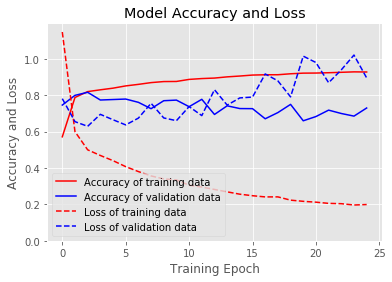

              precision    recall  f1-score   support

         0.0       0.65      0.72      0.68      1864
         1.0       0.98      0.97      0.97      6567
         2.0       0.99      0.99      0.99      1050
         3.0       0.99      1.00      0.99       833
         4.0       0.71      0.62      0.66      2342
         5.0       0.91      0.92      0.91      8212

   micro avg       0.89      0.89      0.89     20868
   macro avg       0.87      0.87      0.87     20868
weighted avg       0.89      0.89      0.89     20868



In [20]:
from sklearn import metrics
from sklearn.metrics import classification_report
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_acc'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model_m.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

In [21]:
df_test.head()
df_test = df_test[["user-id","Activity_code","timestamp","x-axis","y-axis","z-axis"]]

In [22]:
x_test, y_test = create_segments_and_labels(df_test,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

In [23]:
print('x_test shape: ', x_test.shape)
print(x_test.shape[0], 'training samples')
print('y_test shape: ', y_test.shape)

x_test shape:  (6584, 80, 3)
6584 training samples
y_test shape:  (6584,)


In [24]:
# Read the testing labels
y_test_df = df_test["Activity_code"]
# One-hot encode the integer labels
y_test = to_categorical(y_test_df)
y_test.shape


(263423, 6)

In [25]:
input_shape = (num_time_periods*num_sensors)
x_test = x_test.reshape(x_test.shape[0], input_shape)
print('x_train shape:', x_test.shape)
print('input_shape:', input_shape)

x_train shape: (6584, 240)
input_shape: 240


In [26]:
print('\nPrediction from Keras:')
test_record = x_test[1].reshape(1,input_shape)
keras_prediction = np.argmax(model_m.predict(test_record), axis=1)


Prediction from Keras:


In [28]:
# Save the model
model_m.save("smartphone_trained_v3.h5")

In [29]:
# Load the model
from tensorflow.keras.models import load_model
model = load_model("smartphone_trained_v3.h5")

In [30]:
# Grab just one data point to test with
test = np.expand_dims(x_test[0], axis=0)
test.shape

(1, 240)

In [31]:
# Make a prediction. The result should be 1 - Jogging
print(f"Predicted class: {model.predict_classes(test)}")

Predicted class: [1]


In [32]:
df_test.head(1)

,user-id,Activity_code,timestamp,x-axis,y-axis,z-axis
0,33,1,49105962326000,-0.198203,0.804141,0.019539
